# **Random Forest algorithm applied to credit card defaults in Taiwan**

In [40]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
# load the data 
data = pd.read_csv("taiwan credit risk.csv",sep = ";")

In [41]:
# info about the dataset
print("Dimensions of the dataset", data.shape)
print("Number of missing values", data.isna().sum().sum())

# rename incorrect columns 
data = data.rename(columns={"default payment next month": "DEFAULT", 'PAY_0':'PAY_1'})
data.index = data['ID']
data.drop('ID', axis = 1, inplace = True)
data.head(9)

Dimensions of the dataset (30000, 25)
Number of missing values 0


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
7,500000,1,1,2,29,0,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
8,100000,2,2,2,23,0,-1,-1,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
9,140000,2,3,1,28,0,0,2,0,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0


## Description of the Data

There are 30000 records about movements of a bank in Taiwan with its clients (<a href="https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients">here</a> the dataset).
Data referred at the situation on **October 2005**. Both information about the loan and personal charateristics are recorded. In particular the variables are:

* LIMIT_BAL: Amount of given credit (\$)
* SEX (1: Male, 2: Female)
* EDUCATION (1: Graduate School, 2: University, 3: High School, 4: Other)
* MARRIAGE: Martial Status (1: Married, 2: Single, 3: Others)
* AGE 
* PAY_1 - PAY_6: History of past payments from September(1) to April(6) which are coded -1: Payed duly and from 1 to 9: respectivly the number delay month in the payment (9 means "9 or more")
* BILL_AMT1 - BILL_AMT6: Amount of bill statement at each payment (\$)
* PAY_AMT1 - PAY_AMT6: Amount of previous payments (\$)
* DEFAULT: Indicator variable for default in October payment (0: Not Default, 1; Default)



## Descriptive Statistics
### About personal information 

In [3]:
personal_col = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
personal_info = data[personal_col]
personal_info.describe()

,SEX,EDUCATION,MARRIAGE,AGE
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867,35.485500
std,0.489129,0.790349,0.521970,9.217904
min,1.000000,0.000000,0.000000,21.000000
25%,1.000000,1.000000,1.000000,28.000000
50%,2.000000,2.000000,2.000000,34.000000
75%,2.000000,2.000000,2.000000,41.000000
max,2.000000,6.000000,3.000000,79.000000


There are some anomalous values, in particular:
   
* Education = 0
* Education = 5
* Education = 6
* Marriage = 0

Since both Education and Marriage show an 'other' category, the idea is to consider the anomalous observations as 'other'

In [4]:
bin_edu = (data['EDUCATION']==0)|(data['EDUCATION']==5)|(data['EDUCATION']==6)
data.loc[(bin_edu), 'EDUCATION'] = 4
data.loc[(data['MARRIAGE']==0), 'MARRIAGE'] = 3

In [5]:
# A couple of user-defined functions to make plots

def plotter(rows,columns, plot,f_size):
    if rows > 1 and columns > 1:
        grid_plot(rows,columns, plot,f_size)
    else:
        line_plot(rows,columns, plot,f_size)


def grid_plot(rows,columns, plot,f_size):
    
    fig, axs = plt.subplots(rows,columns, figsize= f_size)
    axis = 0 
    axis1 = 0
    for aplot in plot:
        plot_type, plot_data = aplot
        for col in plot_data:
            plot_type(plot_data[col], palette='crest', ax = axs[axis, axis1])
            if axis1 == columns -1 :
                axis+=1 
                axis1=0
            else:
                axis1+=1
                

def line_plot(rows,columns, plot,f_size):
    fig, axs = plt.subplots(rows,columns, figsize= f_size)
    axis = 0 
    for aplot in plot:
        plot_type, plot_data = aplot
        for col in plot_data:
            plot_type(plot_data[col], palette='crest', ax = axs[axis])
            axis +=1




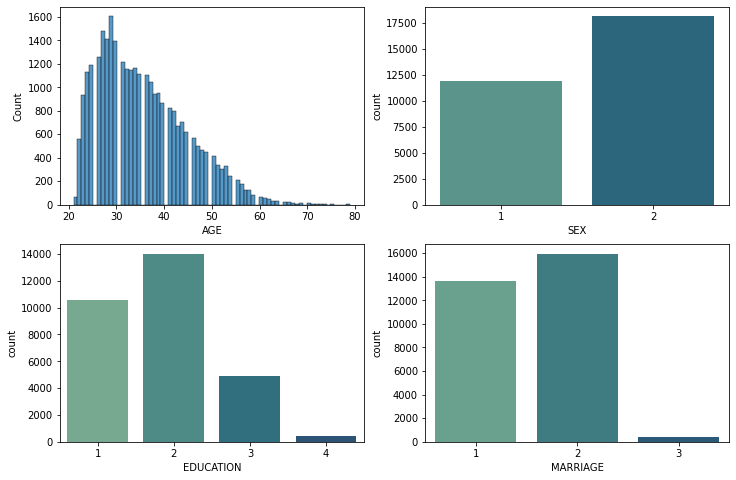

In [6]:
plotter(rows = 2, columns = 2, plot = [(sns.histplot, pd.DataFrame(data['AGE'])), (sns.countplot, data.loc[:, 'SEX':'MARRIAGE'])], f_size = (12,8))

### About loan's information 

In [7]:
loan_info = data.drop(personal_col,axis =1, errors = 'ignore')
loan_info.describe()

,LIMIT_BAL,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


We see that there's a scaling issue: here we've that past payment's coding range from -2 to 8, wheres in the dataset description range is form -1 to 9 so we will simply add 1 to every value

In [8]:
col_pay = data.filter(regex='PAY_[0-9]',axis=1).columns
data[col_pay] = data[col_pay] + 1

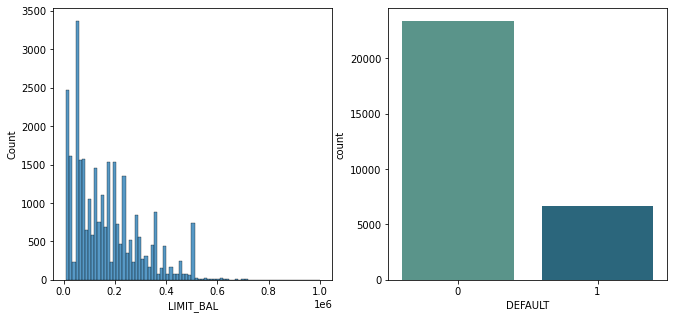

In [10]:
plotter(rows = 1, columns = 2, plot = [(sns.histplot, pd.DataFrame(data['LIMIT_BAL'])), 
                                       (sns.countplot, pd.DataFrame(data['DEFAULT']))], f_size = (11,5))

plt.savefig('class distribution.pdf')

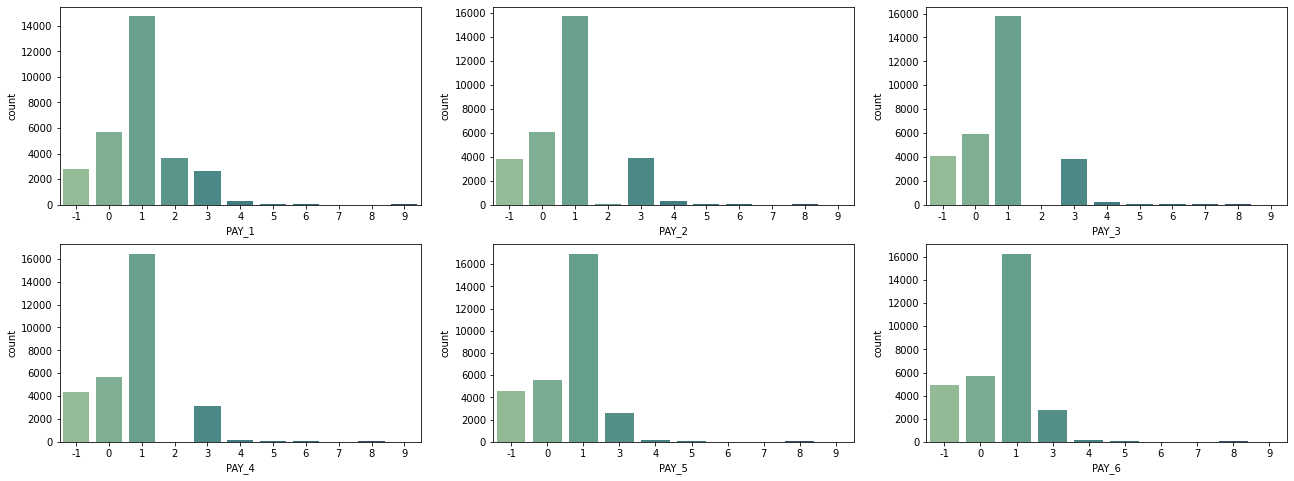

In [11]:
plotter(rows = 2, columns = 3, plot = [(sns.countplot,data.loc[:,'PAY_1':'PAY_6'])], f_size = (22,8))

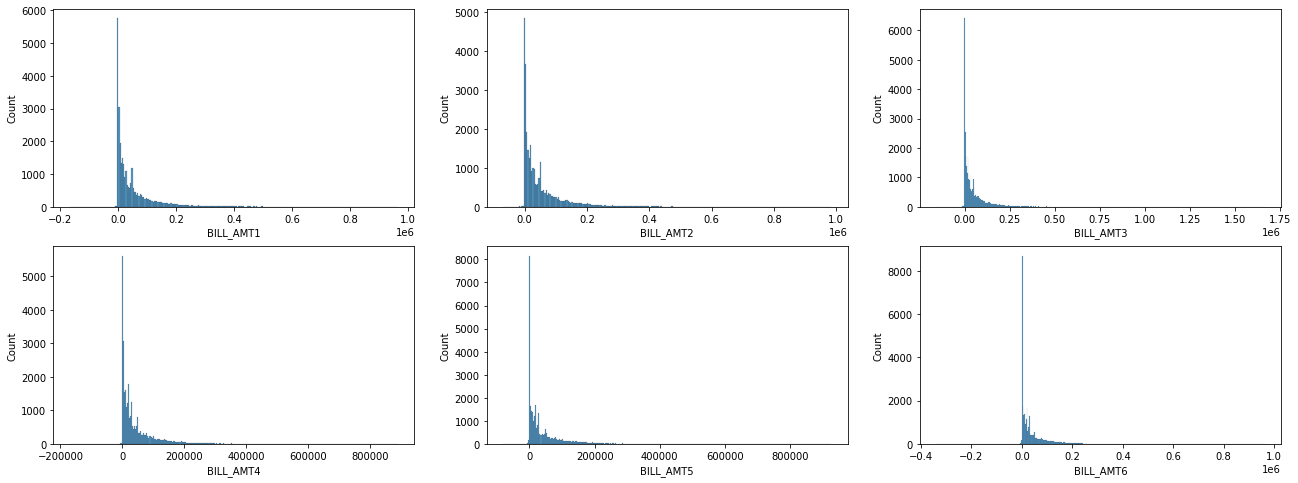

In [12]:
plotter(rows = 2,columns = 3, plot = [(sns.histplot,data.loc[:,'BILL_AMT1':'BILL_AMT6'])], f_size=(22,8))

### Correlation Analysis

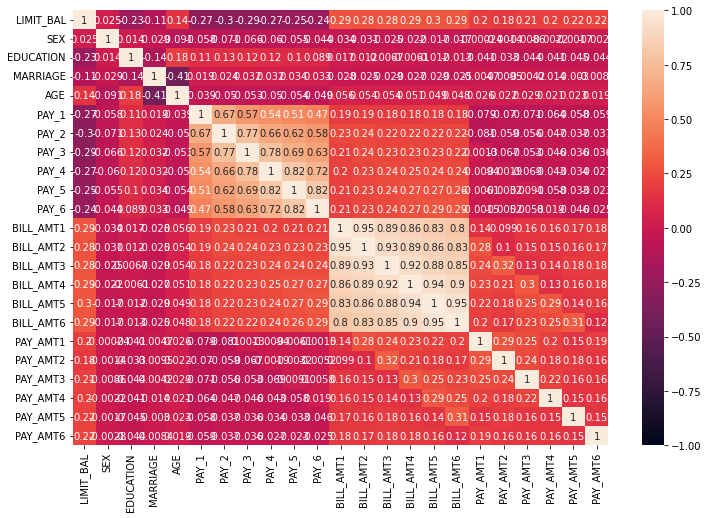

In [13]:
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(data.drop(['DEFAULT'], axis = 1,errors='ignore').corr(), vmin=-1, vmax=1, annot=True)

The idea under the correlation analysis is that if two or more variables are highly correlated, they carry the same amount of information which is redundant. In our data we see that BILL_AMT1 (Bill statement in September 2005) is highly correlated with its value in the past, so we colud drop all the other in the analysis. This will save some computation time and also improve the quality of our predictions.

## Prepare the data for the modelization

It's a good practice to normalize our data to set all the variables on the same scale: we will use the Min-Max Normalization
<br></br>
$$
X_{norm} = \frac{X-X_{min}}{X_{max}-X_{min}}
$$ 

Note that Random Forest it's invariant under the feature scale, but K-NN algorithm as part of SMOTE resampling technique is not, so we normalize the data.

In [14]:

def prepare(data, drop_feat, class_label, norm = False):
    labels = data[class_label]
    features = data.drop(drop_feat, axis = 1, errors = 'ignore')
    if norm:
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(features)
        features = pd.DataFrame(scaled, features.index, features.columns)
    
    return (labels, features)

feat = ['BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','DEFAULT']

labels, features = prepare(data = data, drop_feat = feat,class_label = 'DEFAULT', norm=True)

In [15]:
cases = round(np.sum(labels)/len(labels)*100,3)
print("In the dataset {}% of the observations are default on payment".format(cases))

In the dataset 22.12% of the observations are default on payment


## Metrics 

The main used metric to evaluate the performance of a classification algorithm is the accuracy:
<br></br>
$$
    Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$ 

where: 
* $TP = True \hspace{0.1cm} Positives$
* $TN = True \hspace{0.1cm} Negatives$
* $FP = False \hspace{0.1cm} Positives$
* $FN = False \hspace{0.1cm} Negatives$

which give a general idea of how many observations are correctly classified. One could use this metric in presence of balanced dataset (i.e dataset in which the proportion of observation belonging to each class is approximately equal) and when the cost of missclassification is the same for each class. However in many applications such as banking, medical and so on, the cost of missclassification is not the same and at the same time the number of events that one want to predict correctly is very few, resulting in highly imbalanced datsets. For this reason, it become necessary to consider different metrics to evaluate the performance of our model. We will consider:
<br></br>
$$ 
    Specifity = \frac{TN}{TN+FP}
$$

which give us an idea of how many negative samples are correctly classified w.r.t the real number of negative observations in the sample.
<br></br>
$$ 
    Sensivity = \frac{TP}{TP+FN}
$$

which give us an idea of how many positive samples are correctly classified w.r.t the real number of positive observations in the sample.
<br></br>
$$ 
    Precision = \frac{TP}{TP+FP}
$$

which compares the number of correctly classified as positives over the total number of samples classified as positives.
<br></br>
$$ 
    F1 = 2*\frac{Sensivity*Precision}{Sensivity+Precision}
$$

defined as the harmonic mean between precision and sensivity. Finally we will also consider the AUC (Area Under the ROC Curve), as another measure to compare classification results across different thresholds. On the y-axis we have the Sensivity and on the X-axis the value 1-Specifity. Ideally one would like to be in the upper-left corner where all the positive samples are correctly classified and the value of AUC is 1 (maximum). The area under the bisect is 0.5, which is interpreted as 'random guessing': of course if a model performance is worst than random guessing, it will not be consider a good model. 

**Attention:** the definition of 'positive' and 'negative' samples (binary classification) is completely arbitrary and as consequence the confusion matrix will have a different shape. In particular, from <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html">sklearn documentation</a> we note that the 0's are classified as *negative* and the 1's as *positive*, which is just a little counterintuive respect to the standard adopt in statistics. 

<br></br>



In [16]:
# Define a function for the specifity

def specifity_score(y_test, predicted):
    tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
    specifity = tn/(tn+fp) 
    return specifity

### Splitting the data into training set and test set

In statistical and machine learning, our dataset is always partitioned into 2 parts: 
* A training set: Which represent the majority of the data and will be used to 'train' the model
* A test set: Which represent the unseen data used to evaluate performances of our model

However, if we are unlucky, it may be possible that one randomly choose a 'bad' subset of the data to train the model. To fix this we will also evaluate our model making use of Stratified K-fold cross validation. In K-fold CV the entire dataset is divided into K equal size blocks; k-1 of them are used to train the model and the remaining is used as test set. The procedure terminate when all the blocks are being used as test set. "Stratified" means that each fold is forced to approximaltely preserve the class distribution of the sample in the entire dataset. Each time the model is fitted on a different training set and evaluated on a differnt test set. Final perfomance evaluation is done by taking the mean of each metrics used across the k sets. <a href="https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold">Here</a> an example with three-class calssification problem.



In [17]:

X_train,X_test,Y_train,Y_test = train_test_split(features,labels,test_size=0.30, random_state = 42)
print("Train set dimension", X_train.shape)
print("Test set dimension", X_test.shape)

Train set dimension (21000, 18)
Test set dimension (9000, 18)


In [18]:
good_ = len(Y_train) - Y_train.sum()
bad_ =  Y_train.sum()
ratio = bad_/good_

print('Good borrowers in the train set', good_)
print('Defaults in the train set', bad_)
print('Ratio is', round(ratio,4))

Good borrowers in the train set 16324
Defaults in the train set 4676
Ratio is 0.2864


## Tuning RF Hyperparamters

There are a lot of paramters that must be set a priori in RF such as the number of trees, number of variables, maximum depth of each tree, minimum number of observations in each leaf node and so on. However, since we're implementing a bagging procedure we do not care about overfitting induced by very depth trees: the general idea in RF is to let the tree growing without pruning, since the classification is made by considering the majority vote rule among all the bagged trees. Keeping this in mind we will tune only the number of trees in the forest $B$ and the number of variables considered at each split $m$.

In [54]:
random_forest = RandomForestClassifier(random_state = 42)
parameters = {'n_estimators': [100,200,500,1000,2000],
               'max_features': [1,2,3,'sqrt']}


grid = GridSearchCV(estimator= random_forest, param_grid=parameters, scoring = 'f1', n_jobs= -1)
grid.fit(X_train, Y_train)
grid.best_params_


{'max_features': 'sqrt', 'n_estimators': 2000}

In [19]:
# Here the Random Forest setting defined after tuning 
random_forest = RandomForestClassifier(n_estimators=2000, criterion='gini', max_depth=None, min_samples_split=2,
                                       min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, 
                                       min_impurity_decrease=0.0, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42, 
                                       verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)


# Random Forest on imbalanced data

In [20]:
# define some functions to implement modelization and perfromance evaluation of the models

def fit_predict(classifier, X_train, Y_train, X_test):
    model = classifier.fit(X_train, Y_train)
    prediction = model.predict(X_test)
    return model, prediction

def performance(Y_test,predict):
    accuracy = metrics.accuracy_score(Y_test, predict)
    specifity = specifity_score(Y_test, predict)
    sensivity = metrics.recall_score(Y_test, predict)
    precision = metrics.precision_score(Y_test, predict)
    f1_score = metrics.f1_score(Y_test, predict)
    auc = metrics.roc_auc_score(Y_test, predict)
    return [accuracy, specifity ,sensivity,precision,f1_score, auc]

## Fit the model

In [21]:
metrics_df = pd.DataFrame(index = ["Accuracy", "Specifity", "Sensivity","Precision","F1-score","AUC-score"])
model, prediction = fit_predict(random_forest, X_train, Y_train, X_test)
metrics_df['RF IMB'] = performance(Y_test, prediction)
metrics_df

,RF IMB
Accuracy,0.816333
Specifity,0.939205
Sensivity,0.375000
Precision,0.631986
F1-score,0.470701
AUC-score,0.657102


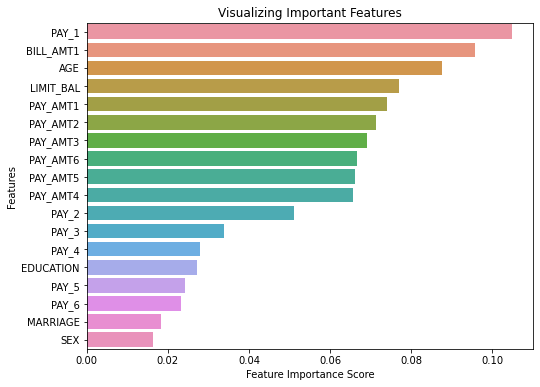

In [22]:
# feature importance 
feature_imp = pd.Series(model.feature_importances_,index=features.columns).sort_values(ascending=False)
%matplotlib inline
# Creating a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

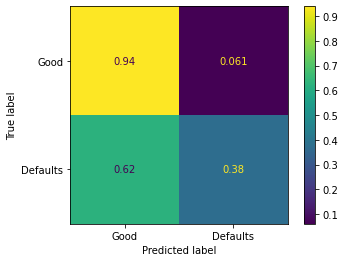

In [26]:
# plotting confusion matrix

plot_confusion_matrix(model, X_test, Y_test, display_labels=["Good", "Defaults"], normalize = 'true')  
plt.grid(False)
plt.savefig('cm imb.pdf')

### Stratified cross validation to evaluate results


In [60]:

def SKfoldEval(X,Y,classifier,k=5):
    strkf = StratifiedKFold(n_splits = k, shuffle = True)
    metrics_cv = pd.DataFrame(index = ["Accuracy", "Specifity", "Sensivity","Precision","F1-score","AUC-score"])
    model_name = 0
    for train_index, test_index in strkf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        model, prediction = fit_predict(classifier, X_train, Y_train, X_test)
        metrics_cv['CV'+str(model_name)] = performance(Y_test,prediction)
        model_name +=1 
    metrics_cv['mean_score'] = metrics_cv.mean(axis=1)
    return metrics_cv 

In [61]:
cross_val_metrics = SKfoldEval(np.array(features), np.array(labels), random_forest)
cross_val_metrics

,CV0,CV1,CV2,CV3,CV4,mean_score
Accuracy,0.815333,0.819833,0.814333,0.815833,0.819500,0.816967
Specifity,0.939640,0.942435,0.933661,0.944575,0.944575,0.940978
Sensivity,0.378012,0.388093,0.394122,0.362472,0.379050,0.380350
Precision,0.640306,0.656888,0.627851,0.650000,0.660105,0.647030
F1-score,0.475379,0.487920,0.484259,0.465409,0.481570,0.478907
AUC-score,0.658826,0.665264,0.663892,0.653523,0.661813,0.660664


**Comment**: We've obtained 82% accuracy which is quietly good. But if we look at the values of specifity and sensivity, we note that our model has an excellent performance in classifying the good borrowers (94% specifity) but it fail in classifying the bad ones (38% sensivity): in that case our bank could loose a relevant amount of money!
<br></br>
**What's wrong?** Random Forest and lot of other algorithms assumes that the class distribution is balanced, but as mentioned above this is not the case. So we need to take into account the problem of class imbalance.



# Resampling Techniques



There is a lot of confusion of how to correctly apply SMOTE (but in general resampling techniques). <a href="https://raw.githubusercontent.com/matteosani/Random-Forest-on-credit-card-defaults/main/block.png?token=GHSAT0AAAAAABP4MLY5GV4ISVWNI66E3CN6YPFUMGA">Here</a> an hand drawn scheme illustrating the correct application.
<br></br>

## Random Forest on Balanced data 


#### Cross validate to define the number of K-NN in SMOTE and the number of trees B


In [62]:
pip = Pipeline([('sampling', SMOTE()),('classification', RandomForestClassifier(random_state = 42))])
k = [i for i in range(1,11)]

k_grid = GridSearchCV(estimator= pip, param_grid= {'sampling__k_neighbors':k, 
                                'classification__n_estimators':[100,200,500,1000,2000]},scoring = 'f1', n_jobs= -1 )
k_grid.fit(X_train,Y_train)
k_grid.best_params_

{'classification__n_estimators': 500, 'sampling__k_neighbors': 3}

### Model implementation 

In [27]:
oversample = SMOTE(k_neighbors= 3)
XO_train ,YO_train= oversample.fit_resample(X_train,Y_train)

In the previous model we considered a training set of 21000 observations where there were 16324 good borrowers and 4676 bad ones. With SMOTE we oversample the minority class until it will have the same amount of samples as the majority class; so we will create 11648 new synthetic samples from the minority class.

<AxesSubplot:xlabel='DEFAULT', ylabel='count'>

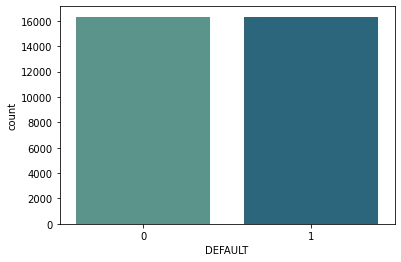

In [28]:
sns.countplot(YO_train, palette='crest')

In [29]:
good_ = len(YO_train) - YO_train.sum()
bad_ =  YO_train.sum()
ratio = bad_/good_

print('Size of the balanced training set', len(YO_train))
print('Good borrowers in the train set', good_)
print('Defaults in the train set', bad_)
print('Ratio is', round(ratio,4))

Size of the balanced training set 32648
Good borrowers in the train set 16324
Defaults in the train set 16324
Ratio is 1.0


In [30]:
random_forest = RandomForestClassifier(n_estimators = 500,oob_score=True, n_jobs=-1, random_state=42)
model_smote, prediction_smote = fit_predict(random_forest, XO_train, YO_train, X_test)
metrics_df['RF SMOTE'] = performance(Y_test, prediction_smote)
metrics_df


,RF IMB,RF SMOTE
Accuracy,0.816333,0.797222
Specifity,0.939205,0.895312
Sensivity,0.375000,0.444898
Precision,0.631986,0.541952
F1-score,0.470701,0.488652
AUC-score,0.657102,0.670105


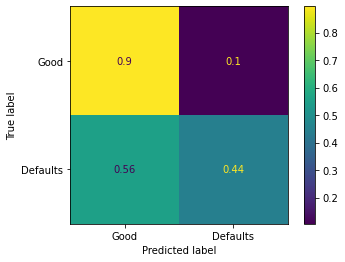

In [31]:
plot_confusion_matrix(model_smote, X_test, Y_test, display_labels=["Good", "Defaults"], normalize = 'true')  
plt.grid(False)
plt.savefig('cm smote.pdf')

In [68]:
smote_classifier = Pipeline([('sampling', SMOTE()),('classification', RandomForestClassifier(n_estimators = 500))])
cross_val_metrics_SM = SKfoldEval(np.array(features), np.array(labels), smote_classifier)

In [69]:
cross_val_metrics_SM

,CV0,CV1,CV2,CV3,CV4,mean_score
Accuracy,0.799333,0.804167,0.803833,0.802000,0.799500,0.801767
Specifity,0.894478,0.903488,0.902204,0.890648,0.897924,0.897749
Sensivity,0.464608,0.454408,0.457423,0.489827,0.452901,0.463834
Precision,0.555856,0.572106,0.570489,0.559862,0.557514,0.563165
F1-score,0.506153,0.506510,0.507737,0.522508,0.499792,0.508540
AUC-score,0.679543,0.678948,0.679813,0.690238,0.675413,0.680791


**Comment**: The accuracy is slightly reduced to 80%. We also notice that the specifity is reduced whereas sensivity is increased (from 34% to 45%), but on the other hand the precision score is reduced. However, looking at the F1 and AUC score, we notice that are both increased so we can assert that SMOTE has improved our model.

### Random Under Sampling (RUS)

In [32]:
undersample = RandomUnderSampler(sampling_strategy='majority')
XU_train, YU_train= undersample.fit_resample(X_train,Y_train)

In [33]:
model_rus, prediction_rus = fit_predict(random_forest, XU_train, YU_train, X_test)
metrics_df['RF RUS'] = performance(Y_test, prediction_rus)
metrics_df

,RF IMB,RF SMOTE,RF RUS
Accuracy,0.816333,0.797222,0.741889
Specifity,0.939205,0.895312,0.774432
Sensivity,0.375000,0.444898,0.625000
Precision,0.631986,0.541952,0.435478
F1-score,0.470701,0.488652,0.513304
AUC-score,0.657102,0.670105,0.699716


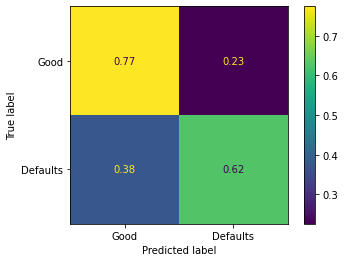

In [34]:
plot_confusion_matrix(model_rus, X_test, Y_test,  display_labels=["Good", "Defaults"], normalize= 'true')  
plt.grid(False)
plt.savefig('cm rus')

In [73]:
rus_classifier = Pipeline([('sampling', RandomUnderSampler(sampling_strategy='majority')),
                           ('classification', RandomForestClassifier(n_estimators = 500))])

cross_val_metrics_RUS = SKfoldEval(np.array(features), np.array(labels), rus_classifier)

In [74]:
cross_val_metrics_RUS

,CV0,CV1,CV2,CV3,CV4,mean_score
Accuracy,0.739667,0.748333,0.745500,0.739333,0.740167,0.742600
Specifity,0.769692,0.777659,0.783223,0.771025,0.766531,0.773626
Sensivity,0.634036,0.645064,0.612660,0.627732,0.647325,0.633363
Precision,0.438999,0.451715,0.445235,0.437730,0.440513,0.442838
F1-score,0.518792,0.531347,0.515699,0.515789,0.524260,0.521178
AUC-score,0.701864,0.711361,0.697941,0.699378,0.706928,0.703495


**Comment**: The accuracy is now 74%. With RUS, our specifity decrease down to 78%, but in contrast about 62% of the default are correctly classified. Both F1 score and AUC are increased w.r.t SMOTE.

### SMOTE + RUS

In [35]:
pip1 = Pipeline([('over', SMOTE(sampling_strategy=0.5)),('under', RandomUnderSampler(sampling_strategy=1))])
XOU_train,YOU_train = pip1.fit_resample(X_train, Y_train)


In [36]:
model_smote_rus, pred_smote_rus = fit_predict(random_forest, XOU_train, YOU_train, X_test)
metrics_df['RF SM+RUS'] = performance(Y_test, pred_smote_rus)
metrics_df

,RF IMB,RF SMOTE,RF RUS,RF SM+RUS
Accuracy,0.816333,0.797222,0.741889,0.771111
Specifity,0.939205,0.895312,0.774432,0.831676
Sensivity,0.375000,0.444898,0.625000,0.553571
Precision,0.631986,0.541952,0.435478,0.477974
F1-score,0.470701,0.488652,0.513304,0.513002
AUC-score,0.657102,0.670105,0.699716,0.692624


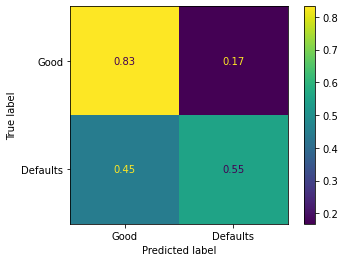

In [39]:
plot_confusion_matrix(model_smote_rus, X_test, Y_test,  display_labels=["Good", "Defaults"], normalize= 'true')  
plt.grid(False)
plt.savefig('cm smoterus.pdf')

In [78]:
smote_rus_classifier = Pipeline([('over', SMOTE(sampling_strategy=0.5)),
                                 ('under', RandomUnderSampler(sampling_strategy=1)),
                                 ('classification', RandomForestClassifier(n_estimators = 500))])
cross_val_metrics_SMRUS = SKfoldEval(np.array(features), np.array(labels), smote_rus_classifier)
cross_val_metrics_SMRUS

,CV0,CV1,CV2,CV3,CV4,mean_score
Accuracy,0.772667,0.770167,0.770500,0.778667,0.783333,0.775067
Specifity,0.830479,0.838220,0.828804,0.833940,0.843783,0.835045
Sensivity,0.569277,0.530520,0.565185,0.584024,0.570460,0.563893
Precision,0.488372,0.482192,0.483871,0.499678,0.509079,0.492638
F1-score,0.525730,0.505203,0.521376,0.538568,0.538024,0.525780
AUC-score,0.699878,0.684370,0.696994,0.708982,0.707122,0.699469


**Comment**: We can see this as a fair compromise between SMOTE and RUS; in particular accuracy is 78% with 84% of specifity and 55% of sensivity. Both AUC and F1 score are incresead w.r.t SMOTE and RUS, so we can assert that the hybrid tecnique works better.

## Conclusion

We've seen that the application of Random Forest algorithm on a dataset which has been balanced through a combination of SMOTE and RUS works pretty well. In the banking field we would like to minimize the number of defaults; however, we need also to keep in mind that if the number of false positives (i.e. real good borrower classified as default) is too high, the bank could deny loans to people that will repay it and so loose money too (given by the high interest rate). An improvement to this analysis can may be achived by considering trasformations of the variables of interest (feature engineering phase), such as definition of particular financial indeces and so on. Finally, further informations about the individuals (e.g income level) could help in improving the quality of the predictions.